In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# LSTM Model for Natural Language Processing

In this notebook I present the process of how the LSTM Model was build including some preprocessing and feature engineering.

Import all the following packages:

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.1.0'

In [4]:
# print(tf.test.gpu_device_name())
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import re

from nltk.corpus import stopwords
from nltk import word_tokenize

STOPWORDS = set(stopwords.words('english'))
from pickle import dump

## Exploratory Data Analysis

In [6]:
# Read preprocessed csv from main notebook
data = pd.read_csv('Datasets/message_length.csv', index_col=0)

In [7]:
# Create a copy for modifications
df = data.copy()

In [8]:
# We will drop several columns that are not useful for this model
df.drop(df.columns.difference(['message','label','Day_of_week', 'message_length']), 1, inplace=True)
df.dropna(axis=0, how='any', inplace=True)
df.reset_index(drop=True, inplace=True)

Exploring our dataset:

In [9]:
df.head()

,message,Day_of_week,message_length,label
0,here is our forecast\n\n,Mon,23,1
1,traveling to have a business meeting takes the...,Fri,786,1
2,test successful. way to go!!!,Wed,30,1
3,"randy,\n\n can you send me a schedule of the s...",Mon,187,1
4,let's shoot for tuesday at 11:45.,Thu,35,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   message         517401 non-null  object
 1   Day_of_week     517401 non-null  object
 2   message_length  517401 non-null  int64 
 3   label           517401 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 15.8+ MB


As we can observe, we have 517401 rows and 4 columns counting the label. Let us convert both the day of the week and the label to categorical columns:

In [11]:
df["label"] = df["label"].astype('category')
df["Day_of_week"] = df["Day_of_week"].astype('category')

Let us perform some exploratory data analysis starting by visualizing our label distribution:

In [12]:
# df['label'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Value Counts',
#                                                                 title='Label Distribution')

We can see that the dataset is heavily bias towards the labels 1 and 2. The label 1 belongs to "sent mail" which is the default folder were emails get send to. This is actually not a label so we can safely drop the rows with label = 1. Label = 2 belongs to emails that we were not able to classify in any other group in the clustering step disccused in the main notebook. We can also safely discard rows where label = 2.

In [13]:
# Dropping rows with label 1 and 2
df = df.drop(df.query('label == 1').sample(frac=1).index)
df = df.drop(df.query('label == 2').sample(frac=1).index)

We can now visualize the new label distribution:

In [14]:
# df['label'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Value Counts', title='Label Distribution')

There are a lot more data points with label = 3 which belongs to legal/corporate emails. Since this dataset belongs to ENRON corporation, it is to be expected that the majority of the emails belong to this class. Let us explore the contents of a few emails:

In [15]:
df = df.reset_index()

In [16]:
# Function to print the message and label for a datapoint
def print_message(index):
    example = df[df.index == index][['message', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Label:', example[1])

In [17]:
print_message(10)

jennifer,
in regard to the costs for the gam conference, karen told me the $ 6,695.97 
figure was inclusive of all the items for the conference.  however, after 
speaking with shweta, i found out this is not the case.  the cds are not 
included in this figure.  

the cd cost will be $2,011.50 + the cost of postage/handling (which is 
currently being tabulated).

colleen

----- forwarded by colleen koenig/na/enron on 12/04/2000 10:56 am -----

	shweta sawhney
	12/04/2000 10:54 am
		 
		 to: colleen koenig/na/enron@enron
		 cc: 
		 subject: quotes for the cd's.

hi,

this is the original quote for this project and it did not include the 
postage. as soon as i have the details from the vendor, i'll forward those to 
you.
please call me if you have any questions.

thanks,
shweta.
----- forwarded by shweta sawhney/na/enron on 12/04/2000 10:52 am -----

	shweta sawhney
	10/30/2000 05:53 pm
		 
		 to: karina prizont/na/enron@enron
		 cc: karen hunter/enron_development@enron_development
		 sub

In [18]:
print_message(1000)

----- forwarded by jeff dasovich/na/enron on 01/26/2001 11:21 am -----

	"julee malinowski-ball" <jmball@ns.net>
	01/26/2001 11:15 am
	please respond to "julee malinowski-ball"
		 
		 to: "william hall" <wfhall2@duke-energy.com>, "tony wetzel" 
<twetzel@thermoecotek.com>, "sue mara" <smara@enron.com>, "steven kelley" 
<steven@iepa.com>, "steve ponder" <steve_ponder@fpl.com>, "stephanie newell" 
<stephanie-newell@reliantenergy.com>, "roger pelote" 
<roger.pelote@williams.com>, "robert lamkin" <rllamkin@seiworldwide.com>, 
"richard hyde" <rwhyde@duke-energy.com>, "paula soos" 
<paula_soos@ogden-energy.com>, "nam nguyen" <nam.nguyen@powersrc.com>, "marty 
mcfadden" <marty_mcfadden@ogden-energy.com>, "lynn lednicky" 
<lale@dynegy.com>, "kent palmerton" <kent.palmerton@williams.com>, "ken 
hoffman" <khoffman@caithnessenergy.com>, "kassandra gough" 
<kgough@calpine.com>, "jonathan weisgall" <jweisgall@aol.com>, "john stout" 
<john_h_stout@reliantenergy.com>, "joe ronan" <joer@calpine.com>, "

### Preprocessing: Cleaning Text 

Let us do some text cleaning since NLP models work better in clean text especially withouth unnecessary spaces.

In [19]:
df = df.reset_index(drop=True)
regex = r"\S*@\S*\s?"
subst = ""
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

# Fucntion for joining parragraphs and words and replacing specific characters by a space:
def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = re.sub(regex, subst, text, 0)
    text = ' '.join(word for word in text.split())
    return text
df['message'] = df['message'].apply(clean_text)

Know let us print the same two messages that we're previously showed to see the changes:

In [20]:
print_message(10)

jennifer in regard to the costs for the gam conference karen told me the $ 6 695.97 figure was inclusive of all the items for the conference. however after speaking with shweta i found out this is not the case. the cds are not included in this figure. the cd cost will be $2 011.50 + the cost of postage handling which is currently being tabulated . colleen ----- forwarded by colleen koenig na enron on 12 04 2000 10:56 am ----- shweta sawhney 12 04 2000 10:54 am to: colleen koenig na enron enron cc: subject: quotes for the cd's. hi this is the original quote for this project and it did not include the postage. as soon as i have the details from the vendor i'll forward those to you. please call me if you have any questions. thanks shweta. ----- forwarded by shweta sawhney na enron on 12 04 2000 10:52 am ----- shweta sawhney 10 30 2000 05:53 pm to: karina prizont na enron enron cc: karen hunter enron_development enron_development subject: quotes for the cd's. hi we have recieved the quotes

In [21]:
print_message(1000)

----- forwarded by jeff dasovich na enron on 01 26 2001 11:21 am ----- "julee malinowski-ball" <jmball ns.net> 01 26 2001 11:15 am please respond to "julee malinowski-ball" to: "william hall" <wfhall2 duke-energy.com> "tony wetzel" <twetzel thermoecotek.com> "sue mara" <smara enron.com> "steven kelley" <steven iepa.com> "steve ponder" <steve_ponder fpl.com> "stephanie newell" <stephanie-newell reliantenergy.com> "roger pelote" <roger.pelote williams.com> "robert lamkin" <rllamkin seiworldwide.com> "richard hyde" <rwhyde duke-energy.com> "paula soos" <paula_soos ogden-energy.com> "nam nguyen" <nam.nguyen powersrc.com> "marty mcfadden" <marty_mcfadden ogden-energy.com> "lynn lednicky" <lale dynegy.com> "kent palmerton" <kent.palmerton williams.com> "ken hoffman" <khoffman caithnessenergy.com> "kassandra gough" <kgough calpine.com> "jonathan weisgall" <jweisgall aol.com> "john stout" <john_h_stout reliantenergy.com> "joe ronan" <joer calpine.com> "joe greco" <joe.greco uaecorp.com> "jim w

We can see that our text is cleaner and more concise. Let us do the embedding now.

## Building the Embedding

We will beging by fixing the number of words to take to generate the embedding. We will fix the input for prediction to 250 characters. We could do longer but for the purposese of this class we will stick with 250. The embedding will be taken arbitrarly to 100 dimensions:

In [22]:
# Maximum number of words based on highest frequency:
max_words = 1000000 
# Maximum number of words to be accepted when predicting. 
max_length = 250
# Setting the dimension of the embedding.
embedding_dim = 100

Let us tokenize the message:

In [23]:
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['message'].values)
word_index = tokenizer.word_index

We will save the tokenizer with the pickle package since it will be a requirement when using the model for future predictions:

In [24]:
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Let us use the tokenizer to turn the text into sequences:

In [25]:
X = tokenizer.texts_to_sequences(df['message'].values)
X = pad_sequences(X, maxlen=max_length)

We can see that the shape of our sequence is the one we expected in the word embedding:

In [26]:
X.shape

(29141, 250)

Since we have 11 possible categories (labels) we need to one hot encode the label column. This means our problem is not a binary classification problem, but a multi-class text classification problem.

In [27]:
Y = pd.get_dummies(df['label']).values

In [28]:
type(X)

numpy.ndarray

Let us convert our message embedding into a dataframe so we can manipulate it in concert with the other dataframes:

In [29]:
X_vir = X.copy()
Y_vir = Y.copy()

Let us copy X and Y for later use since they will be modified for testing:

In [30]:
#Turns X into a dataframe
array = pd.DataFrame(data=X)

In [31]:
array.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0,0,0,0,0,0,0,0,0,0,...,31,14,59,225,77,1124,76015,5,13,5
1,0,0,0,0,0,0,0,0,0,0,...,615,758,76023,56189,17,29,132,56189,17,76024
2,0,0,0,0,0,0,0,0,0,0,...,6385,7909,349,23,265,1825,5,374,1365,6669
3,0,0,0,0,0,0,0,0,0,0,...,17,2135,8047,13689,26431,98,132,32619,17,26431
4,366,137,1915,47,10180,1061,8563,1816,100,21,...,5,708,3672,560,16,2485,14,86,1957,76038


In [58]:
#Concatenating the dataframe with the 250 vector representation dataframe
result = pd.concat([df, array], axis=1)

In [59]:
result = result.drop(labels=['index','message'], axis=1)

In [60]:
result["Day_of_week"] = result["Day_of_week"].astype('category')

In [61]:
result.head()

,Day_of_week,message_length,label,0,1,2,3,4,5,6,...,240,241,242,243,244,245,246,247,248,249
0,Tue,262,0,0,0,0,0,0,0,0,...,31,14,59,225,77,1124,76015,5,13,5
1,Thu,1255,0,0,0,0,0,0,0,0,...,615,758,76023,56189,17,29,132,56189,17,76024
2,Thu,1120,0,0,0,0,0,0,0,0,...,6385,7909,349,23,265,1825,5,374,1365,6669
3,Thu,541,0,0,0,0,0,0,0,0,...,17,2135,8047,13689,26431,98,132,32619,17,26431
4,Fri,1415,0,366,137,1915,47,10180,1061,8563,...,5,708,3672,560,16,2485,14,86,1957,76038


In [62]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29141 entries, 0 to 29140
Columns: 253 entries, Day_of_week to 249
dtypes: category(2), int32(250), int64(1)
memory usage: 28.1 MB


Let us one-hot encode the day of the week:

In [63]:
dfDummies = pd.get_dummies(result['Day_of_week'], prefix = 'Day= ')

In [64]:
dfDummies.head()

,Day= _Fri,Day= _Mon,Day= _Sat,Day= _Sun,Day= _Thu,Day= _Tue,Day= _Wed
0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0


In [65]:
result = pd.concat([result, dfDummies], axis=1)

In [66]:
result = result.drop(labels='Day_of_week', axis=1)

Having done all the preprocessing we know have our final dataframe which consists on 259 columns.

In [67]:
result.head()

,message_length,label,0,1,2,3,4,5,6,7,...,247,248,249,Day= _Fri,Day= _Mon,Day= _Sat,Day= _Sun,Day= _Thu,Day= _Tue,Day= _Wed
0,262,0,0,0,0,0,0,0,0,0,...,5,13,5,0,0,0,0,0,1,0
1,1255,0,0,0,0,0,0,0,0,0,...,56189,17,76024,0,0,0,0,1,0,0
2,1120,0,0,0,0,0,0,0,0,0,...,374,1365,6669,0,0,0,0,1,0,0
3,541,0,0,0,0,0,0,0,0,0,...,32619,17,26431,0,0,0,0,1,0,0
4,1415,0,366,137,1915,47,10180,1061,8563,1816,...,86,1957,76038,1,0,0,0,0,0,0


It is important to normalize numerical values like the message length and maybe the vector representation. We will leave it as it is but we will later test the effect of normalizing the 250 vector representation.

In [70]:
result.iloc[:,:252]

,message_length,label,0,1,2,3,4,5,6,7,...,240,241,242,243,244,245,246,247,248,249
0,262,0,0,0,0,0,0,0,0,0,...,31,14,59,225,77,1124,76015,5,13,5
1,1255,0,0,0,0,0,0,0,0,0,...,615,758,76023,56189,17,29,132,56189,17,76024
2,1120,0,0,0,0,0,0,0,0,0,...,6385,7909,349,23,265,1825,5,374,1365,6669
3,541,0,0,0,0,0,0,0,0,0,...,17,2135,8047,13689,26431,98,132,32619,17,26431
4,1415,0,366,137,1915,47,10180,1061,8563,1816,...,5,708,3672,560,16,2485,14,86,1957,76038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29136,700,8,0,0,0,0,0,0,0,0,...,44,137,77,1193,2030,1449,2469,8248,693,183
29137,510,8,0,0,0,0,0,0,0,0,...,10368,1668,46331,176,316,10289,6979,17,76005,183
29138,6981,8,1860,485,1651,18,870,37,101,446,...,1142,15083,231,154,3985,17195,1027,154,6870,21750
29139,3965,8,1573,16,1788,13,22,686,35,720,...,21190,519,10368,1668,46331,176,316,10289,6979,17


In [71]:
from sklearn import preprocessing
x = result[['message_length']].values #returns a numpy array
# x = result.iloc[:,:252].values #returns a numpy array

In [72]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
result['message_length'] = pd.DataFrame(x_scaled)
# result.iloc[:,:252] = pd.DataFrame(x_scaled)

In [73]:
X = result.loc[:, result.columns != 'label']

In [74]:
#Y = result['label']
Y = pd.get_dummies(result['label']).values

It is time now to split our dataset into a training and testing set. It is improtant that we do this in a stratiffied way since the label distribution is non uniform. Notice the stratify parameter in the train_test_split() method:

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42, stratify=Y)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(26226, 258) (26226, 11)
(2915, 258) (2915, 11)


We will now separate the word embedding representation from the messae length and the one hot encoded day of the week:

In [76]:
X_train_emb = X_train.drop(['message_length', 'Day= _Fri', 'Day= _Mon', 'Day= _Sat', 'Day= _Sun', 'Day= _Thu', 'Day= _Tue', 'Day= _Wed'], axis=1)
X_train_noemb = X_train[['message_length', 'Day= _Fri', 'Day= _Mon', 'Day= _Sat', 'Day= _Sun', 'Day= _Thu', 'Day= _Tue', 'Day= _Wed']]
X_test_emb = X_test.drop(['message_length', 'Day= _Fri', 'Day= _Mon', 'Day= _Sat', 'Day= _Sun', 'Day= _Thu', 'Day= _Tue', 'Day= _Wed'], axis=1)
X_test_noemb = X_test[['message_length', 'Day= _Fri', 'Day= _Mon', 'Day= _Sat', 'Day= _Sun', 'Day= _Thu', 'Day= _Tue', 'Day= _Wed']]

## LSTM Building and Modeling

In [77]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.layers import Flatten, Input, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

Adding the Message length, one hot encoded date actually hurts our model. Therefore we will stick with our previous LSTM Model (only message embedding as input).

### LSTM Model only using the Message Embedding

We will use a simple sequential model since we do not require to pass two inputs: We will also use the same hyperparameters that we specified in the previous model:

In [132]:
model = tf.keras.Sequential([
    Embedding(max_words, embedding_dim, input_length=X_vir.shape[1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 250, 100)          100000000 
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_17 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_18 (Dense)             (None, 11)                1111      
Total params: 100,182,011
Trainable params: 100,182,011
Non-trainable params: 0
_________________________________________________________________


In [133]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 300

history_emb = model.fit(X_train_emb, Y_train, epochs=epochs, 
                    batch_size=batch_size, validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 23603 samples, validate on 2623 samples
Epoch 1/10
23603/23603 [==============================] - 78s 3ms/sample - loss: 1.8928 - accuracy: 0.3871 - val_loss: 1.6948 - val_accuracy: 0.4339
Epoch 2/10
23603/23603 [==============================] - 72s 3ms/sample - loss: 1.4181 - accuracy: 0.5293 - val_loss: 1.3260 - val_accuracy: 0.5612
Epoch 3/10
23603/23603 [==============================] - 73s 3ms/sample - loss: 0.9388 - accuracy: 0.7008 - val_loss: 1.2344 - val_accuracy: 0.5997
Epoch 4/10
23603/23603 [==============================] - 73s 3ms/sample - loss: 0.6365 - accuracy: 0.7987 - val_loss: 1.2908 - val_accuracy: 0.6111
Epoch 5/10
23603/23603 [==============================] - 73s 3ms/sample - loss: 0.4666 - accuracy: 0.8536 - val_loss: 1.3839 - val_accuracy: 0.6138
Epoch 6/10
23603/23603 [==============================] - 72s 3ms/sample - loss: 0.3660 - accuracy: 0.8875 - val_loss: 1.4675 - val_accuracy: 0.6218


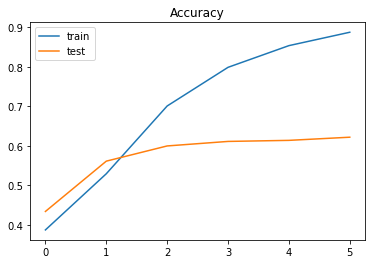

In [134]:
plt.title('Accuracy')
plt.plot(history_emb.history['accuracy'], label='train')
plt.plot(history_emb.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [139]:
model_v2 = Sequential()
model_v2.add(Embedding(max_words, embedding_dim, input_length=X_vir.shape[1]))
model_v2.add(tf.keras.layers.Bidirectional(LSTM(embedding_dim, return_sequences=True)))
model_v2.add(tf.keras.layers.Bidirectional(LSTM(int(embedding_dim/2))))
model_v2.add(Dense(int(embedding_dim/3), activation='relu'))
model_v2.add(Dense(11, activation='softmax'))

model_v2.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 250, 100)          100000000 
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 250, 200)          160800    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 100)               100400    
_________________________________________________________________
dense_19 (Dense)             (None, 33)                3333      
_________________________________________________________________
dense_20 (Dense)             (None, 11)                374       
Total params: 100,264,907
Trainable params: 100,264,907
Non-trainable params: 0
_________________________________________________________________


In [140]:
model_v2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 300

history_emb_v2 = model_v2.fit(X_train_emb, Y_train, epochs=epochs, 
                    batch_size=batch_size, validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 23603 samples, validate on 2623 samples
Epoch 1/10
23603/23603 [==============================] - 78s 3ms/sample - loss: 1.8819 - accuracy: 0.3891 - val_loss: 1.6810 - val_accuracy: 0.4072
Epoch 2/10
23603/23603 [==============================] - 74s 3ms/sample - loss: 1.4954 - accuracy: 0.4902 - val_loss: 1.4171 - val_accuracy: 0.5376
Epoch 3/10
23603/23603 [==============================] - 74s 3ms/sample - loss: 1.0252 - accuracy: 0.6716 - val_loss: 1.2824 - val_accuracy: 0.5928
Epoch 4/10
23603/23603 [==============================] - 75s 3ms/sample - loss: 0.6857 - accuracy: 0.7885 - val_loss: 1.3527 - val_accuracy: 0.6054
Epoch 5/10
23603/23603 [==============================] - 74s 3ms/sample - loss: 0.4901 - accuracy: 0.8543 - val_loss: 1.4006 - val_accuracy: 0.6134
Epoch 6/10
23603/23603 [==============================] - 75s 3ms/sample - loss: 0.3645 - accuracy: 0.8951 - val_loss: 1.4791 - val_accuracy: 0.6096


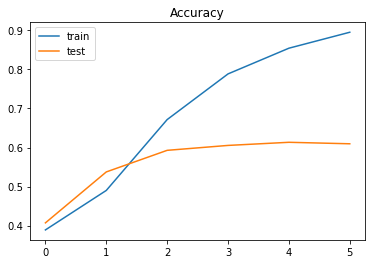

In [141]:
plt.title('Accuracy')
plt.plot(history_emb_v2.history['accuracy'], label='train')
plt.plot(history_emb_v2.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [153]:
model_emb = Sequential()
model_emb.add(Embedding(max_words, embedding_dim, input_length=X_vir.shape[1]))
#model_emb.add(Embedding(max_words, embedding_dim, input_length=X_vir.shape[1], activity_regularizer=regularizers.l1(0.01)))
model_emb.add(SpatialDropout1D(0.2))
model_emb.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_emb.add(Dense(11, activation='softmax'))
model_emb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_emb.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 250, 100)          100000000 
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_21 (Dense)             (None, 11)                1111      
Total params: 100,081,511
Trainable params: 100,081,511
Non-trainable params: 0
_________________________________________________________________
None


Let us train the model for 30 epochs and a batch size of 150, we will do a validation split of 0.1 on the training split, and also use early stopping using validation loss. This will prevent ovefitting the model. 

In [154]:
epochs = 30
batch_size = 150

history_emb = model_emb.fit(X_train_emb, Y_train, epochs=epochs, 
                    batch_size=batch_size, validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 23603 samples, validate on 2623 samples
Epoch 1/30
23603/23603 [==============================] - 157s 7ms/sample - loss: 1.8421 - accuracy: 0.3964 - val_loss: 1.6374 - val_accuracy: 0.4483
Epoch 2/30
23603/23603 [==============================] - 152s 6ms/sample - loss: 1.3819 - accuracy: 0.5501 - val_loss: 1.3203 - val_accuracy: 0.5745
Epoch 3/30
23603/23603 [==============================] - 152s 6ms/sample - loss: 0.9932 - accuracy: 0.6829 - val_loss: 1.2813 - val_accuracy: 0.6069
Epoch 4/30
23603/23603 [==============================] - 152s 6ms/sample - loss: 0.7420 - accuracy: 0.7645 - val_loss: 1.2579 - val_accuracy: 0.6207
Epoch 5/30
23603/23603 [==============================] - 150s 6ms/sample - loss: 0.5754 - accuracy: 0.8149 - val_loss: 1.3095 - val_accuracy: 0.6233
Epoch 6/30
23603/23603 [==============================] - 150s 6ms/sample - loss: 0.4730 - accuracy: 0.8493 - val_loss: 1.3611 - val_accuracy: 0.6195
Epoch 7/30
23603/23603 [===========================

The model early stopped at 6 epochs with an accuracy of 0.8654. Let us save the model:

In [0]:
# save the model to file
model_emb.save('LSTM_OnlyE_30epoch.h5')

Now we can test the model in the test dataset and see our accuracy:

In [155]:
accr = model_emb.evaluate(X_test_emb,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2915/2915 [==============================] - 6s 2ms/sample - loss: 1.4517 - accuracy: 0.6196
Test set
  Loss: 1.452
  Accuracy: 0.620


Let us also see how the model changed over time in terms of loss and accuracy:

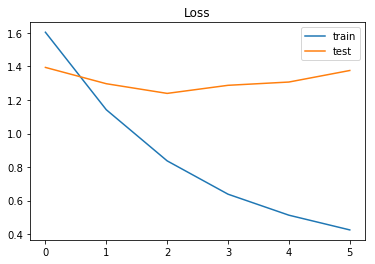

In [0]:
plt.title('Loss')
plt.plot(history_emb.history['loss'], label='train')
plt.plot(history_emb.history['val_loss'], label='test')
plt.legend()
plt.show();

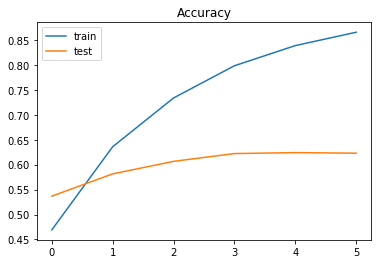

In [0]:
plt.title('Accuracy')
plt.plot(history_emb.history['acc'], label='train')
plt.plot(history_emb.history['val_acc'], label='test')
plt.legend()
plt.show();

We can see that the model loss decrease in the training dataset almost perfectly but the validation dataset did not see any improvement. This signals overfitting of the training split. This is why early stopping was implemented. For onw let us stick with this model and test it but it is important to say that more optimization needs to be done.

## Let us test our model in aribtraty text to which we intuitively know the answer

In [0]:
new_complaint = ['What is the legal consequences of a lawsuite']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length)
pred = model_emb.predict(padded)
labels = ['0','1','2','3','4','5','6','7','8','9','10']
print(pred, labels[np.argmax(pred)])

[[0.05559555 0.00283545 0.00313111 0.51477635 0.13551567 0.12418976
  0.03945212 0.03281857 0.04109936 0.02883642 0.02174963]] 3


In [0]:
new_complaint = ['Have you transferred the funds to the bank account']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length)
pred = model_emb.predict(padded)
labels = ['0','1','2','3','4','5','6','7','8','9','10']
print(pred, labels[np.argmax(pred)])

[[0.206241   0.00180363 0.00147454 0.12211586 0.01405801 0.05601064
  0.02303758 0.5223241  0.03262794 0.00714187 0.01316478]] 7


In [0]:
new_complaint = ['Thank you for contactig us regarding the MBA program, Do you have any questions?']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length)
pred = model_emb.predict(padded)
labels = ['0','1','2','3','4','5','6','7','8','9','10']
print(pred, labels[np.argmax(pred)])

[[0.01847702 0.00082748 0.00112296 0.10232089 0.13056819 0.00560034
  0.00132967 0.00850991 0.1549232  0.02847201 0.54784834]] 10


## Testing two neural networks with two different inputs:

We will create two different neural networks and then combined their output. We will add L1 Regularization to create a sparce and more concise model since we have many feautures

In [0]:
# define two sets of inputs
inputA = Input(shape=(250,)) # Embedding
inputB = Input(shape=(8,)) # Day and length

# the first branch operates on the first input
x = Embedding(max_words, embedding_dim)(inputA)
x = SpatialDropout1D(0.2)(x)
x = LSTM(100, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l1(0.01))(x)
x = Dense(11, activation='softmax')(x)
x = Model(inputs=inputA, outputs=x)

# the second branch opreates on the second input
y = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(11, activation='softmax')(y)
y = Model(inputs=inputB, outputs=y)

# combine the output of the two branches
combined = concatenate([x.output, y.output])

z = Dense(11, activation="softmax")(combined)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 250, 100)     100000000   input_19[0][0]                   
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
spatial_dropout1d_22 (SpatialDr (None, 250, 100)     0           embedding_23[0][0]               
__________________________________________________________________________________________________
dense_40 (

Now that the model is compiled we can pass both inputs (the embedding and the non-embedding features). We will train only for 5 epochs since it takes a long time to train in a batch size of 64. We will do a validation split of 0.1 and we will use early stopping by monitoring validation loss. 

In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
#opt = Adam(lr=1e-3, decay=1e-3 / 200)
#model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

epochs = 5
batch_size = 64

# train the model
print("[INFO] training model...")
history = model.fit([X_train_emb, X_train_noemb], Y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Let us save the model so we can test it later:

In [0]:
model.save('LSTM_ALLfeatures.h5')

Let us evaluate the performance on the test data set:

In [0]:
accr = model.evaluate([X_test_emb, X_test_noemb], Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2915/2915 [==============================] - 6s 2ms/step
Test set
  Loss: 1.950
  Accuracy: 0.386


The model is not performing very well in neither the test data nor the training data. Let us see how the loss and accuracy changed over time.

In [0]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [0]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();